In [1]:

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import random
from tqdm import tqdm



In [2]:
DATA_FOLDER = "../../data"
from torch.utils.data import Dataset

def get_MNIST_data_stats(image_dataset : datasets.MNIST):

    data_set = image_dataset.data
    numpy_data = image_dataset.transform( data_set.numpy())
    
    print("--STATS--")
    print(f"Numpy shape: {data_set.cpu().numpy().shape}")
    print(f"Tensor shape: {data_set.size()}")
    print(f"Min: {torch.min(numpy_data)}")
    print(f"Max: {torch.max(numpy_data)}")
    print(f"mean: {torch.mean(numpy_data)}")
    print(f"std: {torch.std(numpy_data)}")
    print(f"var: {torch.var(numpy_data)}")



def show_images(image_data, rows=4, cols=4):
    print(f"Number of images: {len(image_data)}")
    sample_idx = random.randint(0,len(image_data))
    # print(training_data[0])
    print(f"Image index: {sample_idx}, label : {image_data[sample_idx][1]}, image size: {image_data[sample_idx][0].shape}")

    # Showing one image
    plt.imshow(image_data[sample_idx][0].squeeze(),cmap="gray_r")

    figure = plt.figure(figsize=(6, 6))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(image_data), size=(1,)).item()
        img, label = image_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        plt.title(label)
        plt.tight_layout()
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()





In [3]:
def get_custom_transforms(only_basic = True):
    if only_basic:
        return transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])
    else:
        
        return transforms.Compose(
            [ transforms.ToTensor(),
             transforms.Normalize((0.1307,),(0.3081,)),
             transforms.RandomApply([transforms.RandomRotation(degrees=20)],p=0.1),
             #transforms.RandomApply([transforms.RandomCrop(size=(2,2), fill=0)],p=0.1)
             transforms.RandomErasing(p=0.1, scale=(0.02,0.20))
            #  transforms.RandomHorizontalFlip(p=0.1)
             ])

---->TRAINING data with transform
--STATS--
Numpy shape: (60000, 28, 28)
Tensor shape: torch.Size([60000, 28, 28])
Min: -0.4242129623889923
Max: 2.821486711502075
mean: -0.0001283163292100653
std: 1.0000253915786743
var: 1.0000507831573486
Number of images: 60000
Image index: 13177, label : 1, image size: torch.Size([1, 28, 28])


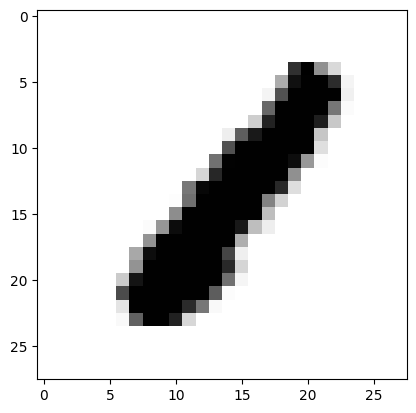

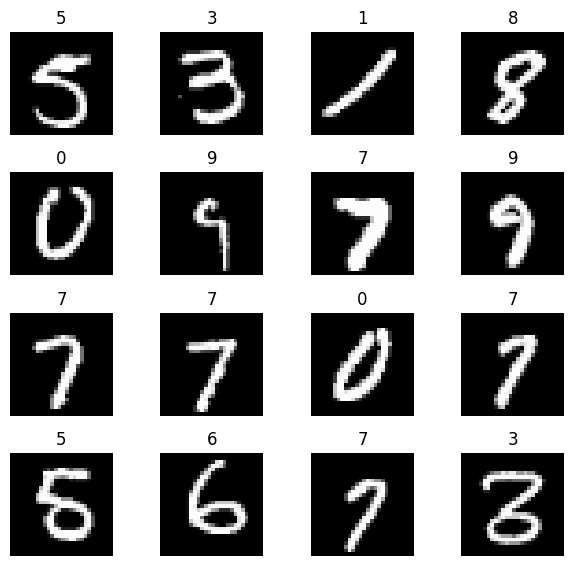

---->TEST data with basic transform
--STATS--
Numpy shape: (10000, 28, 28)
Tensor shape: torch.Size([10000, 28, 28])
Min: -0.4242129623889923
Max: 2.821486711502075
mean: 0.0058896602131426334
std: 1.007725715637207
var: 1.015511155128479
Number of images: 10000
Image index: 179, label : 8, image size: torch.Size([1, 28, 28])


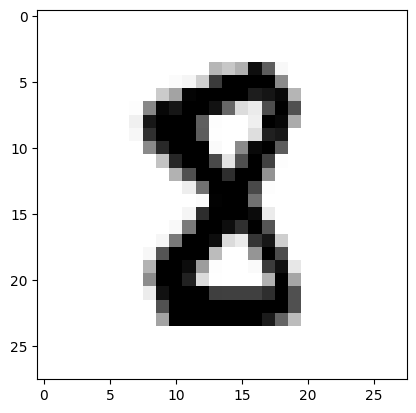

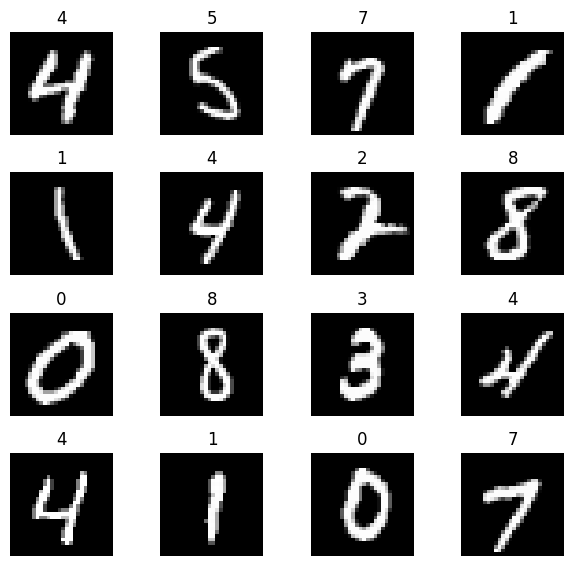

In [4]:

# Download training data from open datasets.

train_dataset = datasets.MNIST(
    root=DATA_FOLDER,
    train=True,
    download=True,
    transform=get_custom_transforms(only_basic=True)
)


# Download test data from open datasets.

test_dataset = datasets.MNIST(
    root=DATA_FOLDER,
    train=False,
    download=True,
    transform=get_custom_transforms(only_basic=True)
)

print("---->TRAINING data with transform")
get_MNIST_data_stats(train_dataset)
show_images(train_dataset)


print("---->TEST data with basic transform")
get_MNIST_data_stats(test_dataset)
show_images(test_dataset)


In [5]:
is_gpu_available = torch.cuda.is_available()
SEED = 1
device = "cpu"
if(is_gpu_available):
    device = "cuda"
    # This ensures that computations involving randomness on the GPU will produce the same results
    # when the seed is the same, even if you run the code multiple times.
    torch.cuda.manual_seed(SEED)

print(f"device: {device}")

device: cuda


In [6]:
BATCH_SIZE = 128

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

for data, target in test_dataloader:
#  X would likely be a tensor containing the pixel values of a batch of grayscale images 
# (e.g., shape: (batch_size, 1 channel, 28, 28)).
# y would contain the corresponding labels for each image, indicating the actual digit represented in the image 
# (e.g., a tensor of shape (batch_size,) containing integer values between 0 and 9).
    print(f"Shape of X [Batch, C, H, W]: {data.shape}")
    print(f"Shape of y (label): {target.shape} {target.dtype}")
    break

Shape of X [Batch, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y (label): torch.Size([128]) torch.int64


In [7]:
def count_parameters(model, input_size=(1,28,28)):
    summary(model=model, input_size=input_size)   
    params = model.state_dict()
    total_parameters =  sum(p.numel() for p in params.values())
    print(f"Total parameters : {total_parameters}")
    return total_parameters

In [8]:
class Net1(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024,out_channels=10,kernel_size=3,padding=0),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=1)


In [15]:
class Net2(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=0),
            nn.ReLU(),
        )

        # Max pool & Transition block
        self.layer2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128,out_channels=32,kernel_size=1,padding=0),
            nn.ReLU(),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=10,kernel_size=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(7,7),padding=0),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=1)

In [16]:
def get_model_instance(index=0) -> nn.Module:
    if(index <= 1 ):
        return Net1().to(device=device)
    elif(index <= 2):
        return Net2().to(device=device)

In [18]:
TARGET_PARAMETER_COUNT = 20000

model = get_model_instance(index=2)

actual_parameter_count = count_parameters(model)
IS_OK = False
if(actual_parameter_count <= TARGET_PARAMETER_COUNT):    
    IS_OK = True

print(f"Parameters criteria IS_OK: {IS_OK}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,856
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,128
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,496
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,856
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [-1, 1

In [19]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):

    model.train()
    pbar = tqdm(dataloader)
    
    train_loss = 0
    correct = 0
    processed = 0

    for batch_id, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        # Compute prediction and loss

        optimizer.zero_grad()
        pred = model(data)
        loss = loss_fn(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_id} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(dataloader))


In [21]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            test_loss += loss_fn(pred, target).item()
            correct += GetCorrectPredCount(pred, target)

    test_loss /= num_batches
    test_acc.append(100. * correct / len(dataloader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))


In [23]:
LEARNING_RATE = 0.01
EPOCHS = 20
MOMENTUM = 0.29


loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)


for t in range(EPOCHS):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1


Train: Loss=0.1231 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]


Test set: Average loss: 0.0559, Accuracy: 9812/10000 (98.12%)

Epoch 2


Train: Loss=0.0133 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]


Test set: Average loss: 0.0462, Accuracy: 9845/10000 (98.45%)

Epoch 3


Train: Loss=0.0071 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]


Test set: Average loss: 0.0457, Accuracy: 9856/10000 (98.56%)

Epoch 4


Train: Loss=0.0908 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]


Test set: Average loss: 0.0483, Accuracy: 9843/10000 (98.43%)

Epoch 5


Train: Loss=0.0358 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]


Test set: Average loss: 0.0465, Accuracy: 9841/10000 (98.41%)

Epoch 6


Train: Loss=0.0154 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]


Test set: Average loss: 0.0485, Accuracy: 9855/10000 (98.55%)

Epoch 7


Train: Loss=0.0192 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]


Test set: Average loss: 0.0514, Accuracy: 9842/10000 (98.42%)

Epoch 8


Train: Loss=0.0140 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]


Test set: Average loss: 0.0472, Accuracy: 9856/10000 (98.56%)

Epoch 9


Train: Loss=0.0483 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]


Test set: Average loss: 0.0447, Accuracy: 9853/10000 (98.53%)

Epoch 10


Train: Loss=0.0078 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]


Test set: Average loss: 0.0533, Accuracy: 9843/10000 (98.43%)

Epoch 11


Train: Loss=0.0546 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]


Test set: Average loss: 0.0476, Accuracy: 9853/10000 (98.53%)

Epoch 12


Train: Loss=0.0749 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]


Test set: Average loss: 0.0513, Accuracy: 9853/10000 (98.53%)

Epoch 13


Train: Loss=0.0279 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]


Test set: Average loss: 0.0475, Accuracy: 9848/10000 (98.48%)

Epoch 14


Train: Loss=0.0531 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]


Test set: Average loss: 0.0438, Accuracy: 9864/10000 (98.64%)

Epoch 15


Train: Loss=0.0437 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]


Test set: Average loss: 0.0509, Accuracy: 9849/10000 (98.49%)

Epoch 16


Train: Loss=0.0029 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]


Test set: Average loss: 0.0422, Accuracy: 9869/10000 (98.69%)

Epoch 17


Train: Loss=0.0033 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]


Test set: Average loss: 0.0431, Accuracy: 9869/10000 (98.69%)

Epoch 18


Train: Loss=0.0150 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]


Test set: Average loss: 0.0427, Accuracy: 9867/10000 (98.67%)

Epoch 19


Train: Loss=0.0144 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]


Test set: Average loss: 0.0428, Accuracy: 9871/10000 (98.71%)

Epoch 20


Train: Loss=0.0007 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]


Test set: Average loss: 0.0430, Accuracy: 9870/10000 (98.70%)

Done!
